# Fig 1B

In [33]:
import os
import numpy as np
import pandas as pd
import scipy.io

import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale = 0.8)

import matplotlib.pyplot as plt
%matplotlib inline

# from ipywidgets import interactive

In [2]:
from custom_functions import loadmat
help(loadmat)

Help on function loadmat in module custom_functions:

loadmat(filename)
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects



## Load data

In [3]:
pwd

'C:\\Users\\ll357\\Documents\\inter\\code\\py_playground'

In [4]:
root_folder = 'C://Users/ll357/Documents/inter/'
# root_folder = 'C:/Users/lan/Documents/repos/inter/'
master_xls_file = 'mat/adp_dataset_master.xlsx'
meta = pd.read_excel(root_folder + master_xls_file, index_col=None)

# meta = meta[meta.seg == 'segmented'].reset_index()
meta = meta[meta.py_plot_ready == 'yes'].reset_index()

meta = meta[['mouse','date','area']]
meta.mouse = meta.mouse.astype(int)
meta.date = meta.date.astype(int)

In [5]:
nset = len(meta.index); ncell = []; nori = 8; nisi = 3; nframe_trial = 223
dir_name = root_folder + 'mat/'

vis_ad = np.empty([0,1]); vis_tg = np.empty([0,1]); well_fit = np.empty([0,1])
ori_pref = np.empty([0,nisi]); fit_param = np.empty([0,7,nisi])
dfof_ad = np.empty([0,1]); dfof_tg = np.empty([0,nori,nisi])
dfof_ad_std = np.empty([0,1]); dfof_tg_std = np.empty([0,nori,nisi])
trace = np.empty([0,nori,nisi,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'cell_property_loose' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    fit_tuning = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'fit_tuning_isi3' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['vis_cell_ad']), axis=0)
    vis_tg = np.concatenate((vis_tg, cell_prop['vis_cell_noad_tg']), axis=0)
    well_fit = np.concatenate((well_fit, cell_prop['well_fit_cell']), axis=0)
    
    ori_pref = np.concatenate((ori_pref, cell_prop['ori_pref']), axis=0)
    fit_param = np.concatenate((fit_param, fit_tuning['fit_param']), axis=0)

    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nisi,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            for iisi in np.arange(nisi):
                trace_flat[icell][iori][iisi][:] = trace_align['trace_avg'][icell][iori][iisi].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, vis_tg.shape, well_fit.shape, ori_pref.shape, fit_param.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([97, 69, 53, 103, 39, 33, 93, 52],
 (539, 1),
 (539, 1),
 (539, 1),
 (539, 3),
 (539, 7, 3),
 (539, 1),
 (539, 8, 3),
 (539, 8, 3, 223))

In [6]:
meta['ncell'] = ncell
# meta = meta.replace({'area' : { 'V1':1, 'LM':2, 'LI':3 }})
meta

,mouse,date,area,ncell
0,1322,200803,V1,97
1,1322,200804,LM,69
2,1322,200806,LI,53
3,1323,200720,V1,103
4,1323,200721,LM,39
5,1323,200723,LI,33
6,1324,200728,V1,93
7,1324,200729,LM,52


In [7]:
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell

,mouse,area
0,1322,V1
1,1322,V1
2,1322,V1
3,1322,V1
4,1322,V1
...,...,...
534,1324,LM
535,1324,LM
536,1324,LM
537,1324,LM


## Adaptation magnitude

adaptation mag = response to target ori==0 with adapter / response to adapter - 1  
cell selection: vis_ad only, no dfof_ad thresholding

In [8]:
adp_mag = dfof_tg[:,0,[1,2]] / dfof_ad - 1

meta_cell_750 = meta_cell.copy(); meta_cell_750['isi'] = 750
meta_cell_250 = meta_cell.copy(); meta_cell_250['isi'] = 250
meta_cell_isi = pd.concat([meta_cell_750, meta_cell_250], ignore_index=True)

df_adp_mag = meta_cell_isi.copy()
df_adp_mag['adp_mag'] = adp_mag.flatten('F')
df_adp_mag['dfof_ad'] = np.concatenate((dfof_ad, dfof_ad), axis=0)

df_adp_mag['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_mag = df_adp_mag[ df_adp_mag['vis_ad'] == 1 ]
df_adp_mag.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
963,1072,1324,LM,250,-0.815490,0.010215,1.0
964,1073,1324,LM,250,-0.744829,0.040586,1.0
965,1074,1324,LM,250,-0.274517,0.037092,1.0
966,1076,1324,LM,250,-1.451877,0.035262,1.0


In [9]:
df_adp_mag[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
           count      mean       std       min       25%       50%       75%   
area isi                                                                       
V1   750   267.0 -0.180326  0.665569 -2.163029 -0.469887 -0.221775  0.077338   
     250   267.0 -0.325477  0.616129 -3.004134 -0.654125 -0.378501 -0.058079   
LM   750   141.0 -0.051040  0.598336 -1.923241 -0.409122 -0.033545  0.211504   
     250   141.0 -0.648543  0.626268 -3.042202 -0.981837 -0.712494 -0.320640   
LI   750    76.0 -0.291396  0.618888 -2.013799 -0.698398 -0.270519  0.103593   
     250    76.0 -0.953516  0.612308 -2.862550 -1.238230 -0.989792 -0.658323   

                    
               max  
area isi            
V1   750  3.502958  
     250  3.622513  
LM   750  2.132582  
     250  1.490129  
LI   750  1.569319  
     250  0.894041

In [11]:
# sns.set_style("whitegrid")
# plt.figure(figsize=(8,5))
# ax = sns.violinplot(data=df_adp_mag, x="area", y="adp_mag", hue="isi",
#                split=True, inner="quart", palette="Set3")
# sns.despine(left=True)
# ax.set(title = 'adaptation magnitude before dfof_ad thresholding')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [13]:
# sns.set_theme(style="whitegrid")
# sns.set_context("talk", font_scale = 0.8)

# plt.figure(figsize=(8,5))
# ax = sns.violinplot(data=df_adp_mag, x="area", y="adp_mag", hue="isi",
#                split=True, inner="quart", palette="Set3")
# sns.despine(left=True)
# ax.set(title = 'adaptation magnitude before dfof_ad thresholding')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### add dfof_ad thresholding

In [15]:
# plt.figure(figsize=(9,6))
# ax = sns.scatterplot(data=df_adp_mag, x="dfof_ad", y="adp_mag", hue="area", style="isi")
# # plt.xlim([0,0.8]);
# plt.xlim([0,0.1]);
# ax.set(title = 'adp mag changes with dfof_ad');

In [17]:
df = df_adp_mag.sort_values(by=['dfof_ad'])
df1 = df[df.isi == 750]
df2 = df[df.isi == 250]

def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).mean(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling mean')
    plt.title('adp mag rolling mean change with dfof_ad of cells')
    plt.show()

# interactive_plot = interactive(f, win=(2, 20))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

In [18]:
def f(win):
    plt.figure(figsize=(15,5))
    plt.plot(df1.dfof_ad, df1['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.plot(df2.dfof_ad, df2['adp_mag'].rolling(win, min_periods=1).std(), alpha=0.7)
    plt.legend(['isi = 750', 'isi = 250'])
    plt.xlim([0,0.1])
    plt.xlabel('dfof_ad')
    plt.ylabel('adaptation mag rolling std')
    plt.title('adp mag rolling std change with dfof_ad of cells')
    plt.show()

# interactive_plot = interactive(f, win=(2, 20))
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

cell selection: vis_ad only, with dfof_ad thresholding

In [19]:
dfof_threshold = 0.03
df_adp_mag_thres = df_adp_mag[df_adp_mag.dfof_ad >= dfof_threshold]
df_adp_mag_thres.reset_index()

,index,mouse,area,isi,adp_mag,dfof_ad,vis_ad
0,0,1322,V1,750,-0.239962,0.083296,1.0
1,1,1322,V1,750,-0.267440,0.079051,1.0
2,2,1322,V1,750,0.092123,0.089755,1.0
3,3,1322,V1,750,-0.258139,0.149961,1.0
4,4,1322,V1,750,-0.049561,0.242218,1.0
...,...,...,...,...,...,...,...
753,1067,1324,LM,250,-1.037747,0.047524,1.0
754,1073,1324,LM,250,-0.744829,0.040586,1.0
755,1074,1324,LM,250,-0.274517,0.037092,1.0
756,1076,1324,LM,250,-1.451877,0.035262,1.0


In [20]:
df_adp_mag_thres[['adp_mag','area','isi']].groupby(['area','isi'], sort=False).describe()

adp_mag                                                              \
           count      mean       std       min       25%       50%       75%   
area isi                                                                       
V1   750   215.0 -0.164490  0.492664 -1.875533 -0.395995 -0.188318  0.040594   
     250   215.0 -0.362663  0.443836 -1.729659 -0.648102 -0.399921 -0.124511   
LM   750   108.0 -0.100791  0.436052 -1.089206 -0.373513 -0.076079  0.111626   
     250   108.0 -0.635745  0.510077 -2.225924 -0.915844 -0.686542 -0.359696   
LI   750    56.0 -0.321286  0.502430 -2.013799 -0.632570 -0.270519 -0.025623   
     250    56.0 -0.922097  0.467841 -1.738642 -1.185452 -0.971112 -0.737692   

                    
               max  
area isi            
V1   750  1.972312  
     250  1.149798  
LM   750  1.369365  
     250  0.703521  
LI   750  0.951508  
     250  0.530749

In [21]:
# sns.set_style("whitegrid")
# plt.figure(figsize=(10,6))
# ax = sns.violinplot(data=df_adp_mag_thres, x="area", y="adp_mag", hue="isi",
#                split=True, inner="quart", palette="Set3")
# sns.despine(left=True)
# ax.set(ylabel = 'adaptation index', title = 'adaptation magnitude after dfof_ad thresholding');
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [48]:
adp_v1 = df_adp_mag_thres[(df_adp_mag_thres.isi==250) & (df_adp_mag_thres.area=='V1')].adp_mag.values
adp_lm = df_adp_mag_thres[(df_adp_mag_thres.isi==250) & (df_adp_mag_thres.area=='LM')].adp_mag.values
adp_li = df_adp_mag_thres[(df_adp_mag_thres.isi==250) & (df_adp_mag_thres.area=='LI')].adp_mag.values

In [51]:
from scipy.stats import ttest_ind

t, p = ttest_ind(adp_v1, adp_lm, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

t, p = ttest_ind(adp_li, adp_lm, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

ttest_ind:            t = 4.73565  p = 4.26017e-06
ttest_ind:            t = -3.60268  p = 0.00045916


## fig 1B

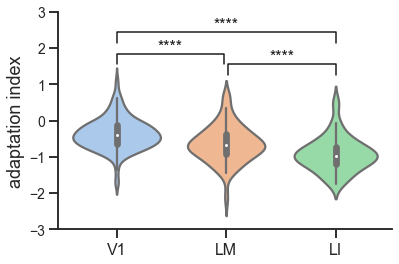

In [197]:
sns.set_style("ticks")
ax = sns.violinplot(x="area", y="adp_mag", col="isi",
                data=df_adp_mag_thres[df_adp_mag_thres.isi==250], kind="violin",
                height=4, aspect=1, palette='pastel');

# statistical annotation
x1, x2 = 0, 0.98
y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 0.4, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

x1, x2 = 1.02, 2
y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 0.1, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

x1, x2 = 0, 2
y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 1, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

plt.xlabel('')
plt.ylabel('adaptation index', fontsize=18)
ax.set_xticklabels(['V1', 'LM', 'LI'], fontsize=18)
ax.set_yticks(np.arange(-3,3.1))
ax.set_ylim((-3,3))

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=14)
sns.despine(ax=ax)

# figtitle = 'Adaptation magnitude increases along ventral stream'
# ax.fig.suptitle(figtitle, size=16)
# ax.fig.subplots_adjust(top=.8)
# ax.savefig(root_folder + 'plot/poster/' + figtitle + '.pdf', format='pdf')


# Fig 1C

In [120]:
import pandas as pd
import numpy as np
import scipy
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from astropy.stats import circvar
from astropy import units as u
import os
# from ipywidgets import interactive

In [121]:
def replace_area_name(df, area_key):
# df = dataframe containing an area array column
# area_key = string

    df[area_key] = df[area_key].replace(1, 'V1')
    df[area_key] = df[area_key].replace(2, 'LM')
    df[area_key] = df[area_key].replace(3, 'LI')
    
    return df

In [122]:
mode = 'hubel'

if mode == 'nuke':
    root_path = "C:/Users/lan/Documents/repos/inter"
elif mode == 'hubel':
    root_path = 'C:/Users/ll357/Documents/inter/'
elif mode == 'linux':
    root_path = '/home/ll357@dhe.duke.edu/inter'

mode, root_path

('hubel', 'C:/Users/ll357/Documents/inter/')

## response amplitude by area

In [123]:
file_path = os.path.join(root_path, "plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit", "amp_area.mat").replace("\\","/")
temp = loadmat(file_path)

df = pd.DataFrame(temp['resp_ad'], columns=['resp_ad'])
df['area_ad'] = temp['area_ad']
df['area_ad'] = df['area_ad'].replace(1, 'V1')
df['area_ad'] = df['area_ad'].replace(2, 'LM')
df['area_ad'] = df['area_ad'].replace(3, 'LI')
df.tail()

,resp_ad,area_ad
479,0.010215,LM
480,0.040586,LM
481,0.037092,LM
482,0.035262,LM
483,0.038123,LM


In [125]:
df2 = pd.DataFrame(temp['resp_tg_collapse_ori'], columns=['resp_tg_avg_ori'])
df2['area_tg'] = temp['area_tg']
df2['area_tg'] = df2['area_tg'].replace(1, 'V1')
df2['area_tg'] = df2['area_tg'].replace(2, 'LM')
df2['area_tg'] = df2['area_tg'].replace(3, 'LI')
# df2.tail()

In [129]:
# df.groupby('area_ad', sort=False).describe().reset_index()

In [130]:
# df2.groupby('area_tg', sort=False).describe().reset_index()

In [131]:
# fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
# fig.suptitle('resp ad or tg by area')

# # resp ad
# ax = sns.violinplot(ax=axes[0,0], x="area_ad", y="resp_ad", data=df)
# axes[0,0].set_title('resp ad')

# # resp tg
# ax = sns.violinplot(ax=axes[0,1], x="area_tg", y="resp_tg_avg_ori", data=df2)
# axes[0,1].set_title('resp tg')

# # resp ad zoom in
# ax = sns.violinplot(ax=axes[1,0], x="area_ad", y="resp_ad", data=df)
# ax.set(ylim=(-0.1, 0.4))
# axes[1,0].set_title('resp ad zoom in')

# # resp tg zoom in
# ax = sns.violinplot(ax=axes[1,1], x="area_tg", y="resp_tg_avg_ori", data=df2)
# ax.set(ylim=(-0.1, 0.4))
# axes[1,1].set_title('resp tg zoom in')

# fig.tight_layout()

### Polar plot of resp_ori by area

In [134]:
ncell_tg = temp['resp_tg'].shape[0]
nori = temp['resp_tg'].shape[1]
resp_tg_cell = []
resp_tg_sorted = np.zeros((ncell_tg, nori))

for icell in np.arange(ncell_tg):
    resp_tg_cell = temp['resp_tg'][icell, :]
    resp_tg_sorted[icell, :] = np.concatenate(
        (resp_tg_cell[np.argmax(resp_tg_cell):len(resp_tg_cell)], 
         resp_tg_cell[0:np.argmax(resp_tg_cell)])) # put max resp to column zero
    
df3 = pd.DataFrame(resp_tg_sorted)
df3['area'] = temp['area_tg']
df3 = replace_area_name(df3, 'area')
df3.head()

,0,1,2,3,4,5,6,7,area
0,0.186297,0.184818,0.095037,0.053145,0.037715,0.041623,0.050704,0.185359,V1
1,0.108755,0.042337,-0.003442,0.007771,-0.021082,-0.017110,0.035048,0.096532,V1
2,0.334310,0.331804,0.054893,0.075347,0.037645,0.046042,0.088307,0.192283,V1
3,0.866983,0.851523,0.237683,0.124013,0.058653,0.050948,0.023531,0.501670,V1
4,0.094991,0.010616,0.023006,0.033687,0.009473,0.022536,0.073898,0.083687,V1


In [136]:
# df3.groupby('area', sort=False).count().reset_index()

In [139]:
df_mean = df3.groupby('area', sort=False).mean().reset_index()
df_mean

,area,0,1,2,3,4,5,6,7
0,V1,0.189429,0.105789,0.061552,0.050540,0.043605,0.048948,0.060476,0.104599
1,LM,0.159020,0.100637,0.078627,0.058909,0.058579,0.063240,0.077658,0.096254
2,LI,0.135697,0.087246,0.066252,0.053657,0.057660,0.068695,0.070728,0.086117


In [140]:
df_median = df3.groupby('area', sort=False).median().reset_index()
df_median

,area,0,1,2,3,4,5,6,7
0,V1,0.144829,0.074164,0.049312,0.036211,0.034849,0.035739,0.044892,0.072835
1,LM,0.118889,0.068838,0.051055,0.040134,0.030842,0.039416,0.047986,0.068135
2,LI,0.106541,0.074895,0.054512,0.049813,0.041845,0.056051,0.057500,0.073321


In [141]:
df_std = df3.groupby('area', sort=False).std().reset_index()
df_std

,area,0,1,2,3,4,5,6,7
0,V1,0.137807,0.106330,0.062236,0.057600,0.046306,0.062865,0.064945,0.104128
1,LM,0.124312,0.111539,0.096953,0.080087,0.086121,0.084268,0.103900,0.105930
2,LI,0.079208,0.057271,0.051583,0.046024,0.050421,0.054776,0.061219,0.066770


In [142]:
arr_median = df_median.to_numpy()
arr_median = arr_median[0:3, 1:nori+1]
chop_idx = 4
arr_median = np.hstack((arr_median[:, chop_idx:], arr_median[:, :chop_idx])) # flip to make max resp ori at the middle
arr_median = np.concatenate((arr_median, arr_median[:,0].reshape([3,1])), axis=1)

arr_mean = df_mean.to_numpy()
arr_mean = arr_mean[0:3, 1:nori+1]
arr_mean = np.hstack((arr_mean[:, chop_idx:], arr_mean[:, :chop_idx]))
arr_mean = np.concatenate((arr_mean, arr_mean[:,0].reshape([3,1])), axis=1)

arr_std = df_std.to_numpy()
arr_std = arr_std[0:3, 1:nori+1]
arr_std = np.hstack((arr_std[:, chop_idx:], arr_std[:, :chop_idx]))
arr_std = np.concatenate((arr_std, arr_std[:,0].reshape([3,1])), axis=1)

ncell_area = df3.groupby('area', sort=False).count().reset_index()[0]
ncell_area = ncell_area.to_numpy().reshape([3,1])
arr_sem = arr_std / np.sqrt(ncell_area)

N = nori * 2
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii_V1_med = np.concatenate((arr_median[0], arr_median[0]))
radii_LM_med = np.concatenate((arr_median[1], arr_median[1]))
radii_LI_med = np.concatenate((arr_median[2], arr_median[2]))
radii_V1_mean = np.concatenate((arr_mean[0], arr_mean[0]))
radii_LM_mean = np.concatenate((arr_mean[1], arr_mean[1]))
radii_LI_mean = np.concatenate((arr_mean[2], arr_mean[2]))
width = np.pi / nori

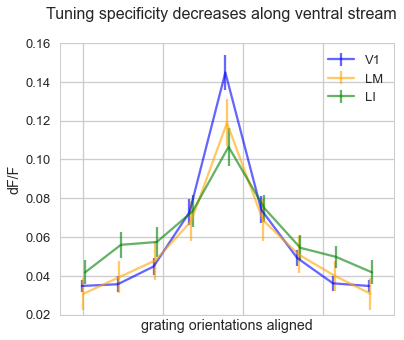

In [149]:
deg = np.linspace(0.0, 180, 8, endpoint=False)
deg = np.asarray([*deg, 180])
# deg = deg[:-1]

# plt.style.use('seaborn-whitegrid')
# plt.figure(figsize=(6, 5))

# plt.errorbar(deg-1, arr_median[0], yerr=arr_sem[0], label='V1', color='blue', alpha=0.6)
# plt.errorbar(deg, arr_median[1], yerr=arr_sem[1], label='LM', color='orange', alpha=0.6)
# plt.errorbar(deg+1, arr_median[2], yerr=arr_sem[2], label='LI', color='green', alpha=0.6)

# plt.xlim([-15,195])
# plt.ylim([0.02,0.16])
# plt.yticks(np.arange(0.02, 0.18, step=0.02))
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
# plt.xlabel('grating orientations aligned')
# plt.ylabel('dF/F')

# figtitle = 'Tuning specificity decreases along ventral stream'
# plt.suptitle(figtitle, size=16)
# plt.legend();
# # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# plt.savefig(root_path + 'plot/poster/' + figtitle + '.pdf', format='pdf')

In [158]:
# plt.figure(figsize=(15, 10))
# ax = plt.subplot(121, projection='polar')
# ax.bar(theta, radii_V1_med, width=width/1.2, bottom=0.0, color='C0', alpha=0.4)
# ax.bar(theta, radii_LM_med, width=width/1.1, bottom=0.0, color='C1', alpha=0.4)
# ax.bar(theta, radii_LI_med, width=width/1.0, bottom=0.0, color='C3', alpha=0.4)
# plt.yticks(np.arange(0, 0.16, step=0.04))
# ax.legend(['V1 239', 'LM 107', 'LI 66'])
# plt.title('median ori resp')

# ax = plt.subplot(122, projection='polar')
# ax.bar(theta, radii_V1_mean, width=width/1.2, bottom=0.0, color='C0', alpha=0.4)
# ax.bar(theta, radii_LM_mean, width=width/1.1, bottom=0.0, color='C1', alpha=0.4)
# ax.bar(theta, radii_LI_mean, width=width/1.0, bottom=0.0, color='C3', alpha=0.4)
# plt.title('mean ori resp')
# plt.yticks(np.arange(0, 0.18, step=0.04))
# plt.show()

## circular variance
cirvar is calculated with positive values only. all negative responses are rectified to 0.  
https://stackoverflow.com/questions/52856232/scipy-circular-variance  
https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Circular_Data_Analysis.pdf  
https://docs.astropy.org/en/stable/api/astropy.stats.circvar.html

In [143]:
file_path = os.path.join(root_path, "plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit", "corr_well_fit_HVA_w_cirvar.mat").replace("\\","/")
temp = loadmat(file_path)

ori_list = np.arange(0, 180, 22.5)
# temp['dfof_tg_ori'].shape

ncell = temp['dfof_tg_ori'].shape[0]
nori = 8
cirvar = np.pi * np.ones((ncell, 1))

for icell in range(0, ncell):
    pseudo = [] # pretend there is a dist of angles, to calculate circular variance
    
    for j in range(0, nori):
        pseudo.append([ori_list[j]] * int(temp['dfof_tg_ori'][icell][j])) 
        pseudo_flat = [item for sublist in pseudo for item in sublist]
        cell_data = np.asarray(pseudo_flat)*u.deg
        cirvar[icell] = float(circvar(cell_data))
        
cirvar.shape

C:\Users\ll357\Miniconda3\lib\site-packages\astropy\units\quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(539, 1)

## ori_perc correlates with?
- areacode, vis_driven, well_fit  
- ori_perc  
- OSI, R2, width, SNR

In [144]:
file_path = os.path.join(root_path, "plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit", "corr_well_fit_HVA.mat").replace("\\","/")
temp = loadmat(file_path)

del temp['__header__']
del temp['__version__']
del temp['__globals__']
temp.keys()

dict_keys(['OSI', 'R2', 'SSE', 'area_merge', 'coeff_var', 'ori_perc_all', 'sharp', 'vis', 'well_fit'])

In [145]:
df = pd.DataFrame(temp['area_merge'], columns=['area'])
for key in temp.keys():
    df[key] = temp[key]

df = df.drop(columns='area_merge')
df['vis_well_fit'] = df['well_fit'] & df['vis'] # true well fit: both visually driven and well fit
df['cirvar'] = cirvar
df['area'] = df['area'].replace(1, 'V1').replace(2, 'LM').replace(3, 'LI')

df = df[['area', 'vis', 'vis_well_fit', 'ori_perc_all', 'well_fit',
    'OSI', 'cirvar', 'sharp', 
    'R2', 'SSE', 'coeff_var']]
df.describe()

,vis,vis_well_fit,ori_perc_all,well_fit,OSI,cirvar,sharp,R2,SSE,coeff_var
count,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,0.931354,0.278293,40.570721,0.302412,0.627859,0.310605,4.856182,0.653765,0.004115,5.489793
std,0.253085,0.448575,23.454350,0.459729,1.195255,0.135826,5.656417,0.275461,0.008089,84.493862
min,0.000000,0.000000,2.408343,0.000000,-17.093486,0.000000,0.346600,-0.695097,0.000059,0.373075
25%,1.000000,0.000000,17.490573,0.000000,0.313496,0.225702,0.916490,0.465905,0.001126,1.043703
50%,1.000000,0.000000,42.538263,0.000000,0.595265,0.307743,2.576697,0.721151,0.002398,1.423818
75%,1.000000,1.000000,57.937636,1.000000,0.895763,0.392258,5.893881,0.886233,0.004475,2.114635
max,1.000000,1.000000,89.977356,1.000000,11.723328,0.740979,20.000000,0.997551,0.142692,1963.122296


## corr btw ori_perc vs all

In [157]:
df['area'] = df['area'].replace('V1',1).replace('LM',2).replace('LI',3)
df_corr = df.corr(method ='pearson')
df_corr[['area', 'vis', 'vis_well_fit', 'ori_perc_all']]

,area,vis,vis_well_fit,ori_perc_all
area,1.000000,-0.080810,-0.302078,0.230669
vis,-0.080810,1.000000,0.168585,0.031716
vis_well_fit,-0.302078,0.168585,1.000000,-0.756020
ori_perc_all,0.230669,0.031716,-0.756020,1.000000
well_fit,-0.294789,-0.028927,0.943129,-0.796569
OSI,0.029047,-0.078676,0.095778,-0.152942
cirvar,-0.057084,0.288578,-0.189930,0.353272
sharp,0.118279,-0.111279,-0.165397,0.238581
R2,-0.167217,0.031158,0.561621,-0.644296
SSE,-0.105474,0.027109,-0.001424,-0.010152


In [158]:
df_corr

,area,vis,vis_well_fit,ori_perc_all,well_fit,OSI,cirvar,sharp,R2,SSE,coeff_var
area,1.000000,-0.080810,-0.302078,0.230669,-0.294789,0.029047,-0.057084,0.118279,-0.167217,-0.105474,0.080715
vis,-0.080810,1.000000,0.168585,0.031716,-0.028927,-0.078676,0.288578,-0.111279,0.031158,0.027109,-0.163824
vis_well_fit,-0.302078,0.168585,1.000000,-0.756020,0.943129,0.095778,-0.189930,-0.165397,0.561621,-0.001424,-0.031896
ori_perc_all,0.230669,0.031716,-0.756020,1.000000,-0.796569,-0.152942,0.353272,0.238581,-0.644296,-0.010152,0.027355
well_fit,-0.294789,-0.028927,0.943129,-0.796569,1.000000,0.117477,-0.271011,-0.156838,0.593172,-0.014326,-0.033222
OSI,0.029047,-0.078676,0.095778,-0.152942,0.117477,1.000000,-0.127640,-0.009227,0.203248,-0.020241,-0.057995
cirvar,-0.057084,0.288578,-0.189930,0.353272,-0.271011,-0.127640,1.000000,-0.040121,-0.056433,0.037891,-0.025076
sharp,0.118279,-0.111279,-0.165397,0.238581,-0.156838,-0.009227,-0.040121,1.000000,-0.116045,-0.109171,-0.026492
R2,-0.167217,0.031158,0.561621,-0.644296,0.593172,0.203248,-0.056433,-0.116045,1.000000,-0.087097,-0.100057
SSE,-0.105474,0.027109,-0.001424,-0.010152,-0.014326,-0.020241,0.037891,-0.109171,-0.087097,1.000000,0.009794


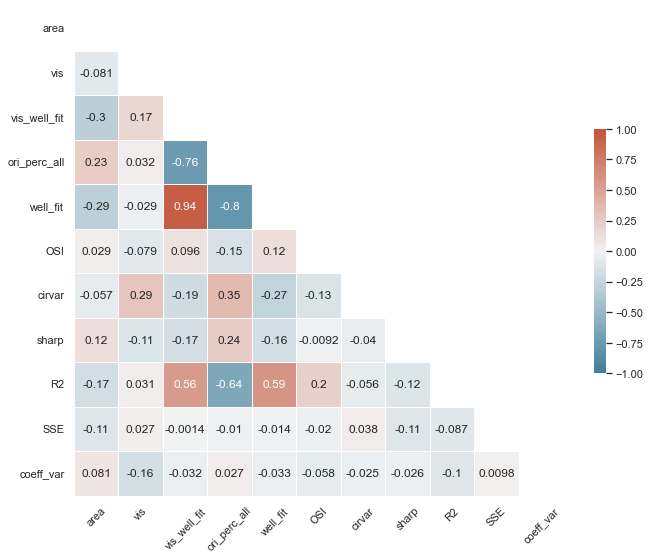

In [159]:
sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(df_corr, dtype=bool)) # Generate a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

sns.heatmap(df_corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45);

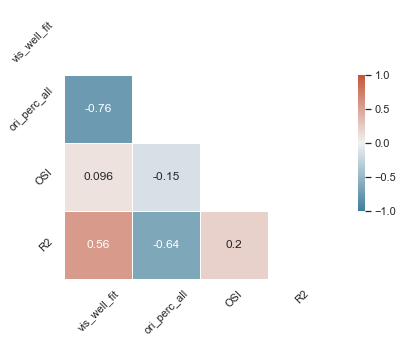

In [160]:
df2 = df[['vis_well_fit','ori_perc_all','OSI','R2']]
df_corr_only = df2.corr(method ='pearson')

sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(8,5))
mask = np.triu(np.ones_like(df_corr_only, dtype=bool)) # Generate a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

sns.heatmap(df_corr_only, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45); plt.yticks(rotation=45);

## find combined metrics of well_fit

In [161]:
df3 = df[['area','vis','vis_well_fit','ori_perc_all','OSI','R2']]
df3.head()

,area,vis,vis_well_fit,ori_perc_all,OSI,R2
0,1,1,1,13.547029,0.663277,0.909820
1,1,1,0,48.059424,0.850999,0.912416
2,1,1,1,7.232809,1.092288,0.982684
3,1,1,1,9.414715,0.797583,0.936868
4,1,1,1,6.014102,0.873269,0.954914


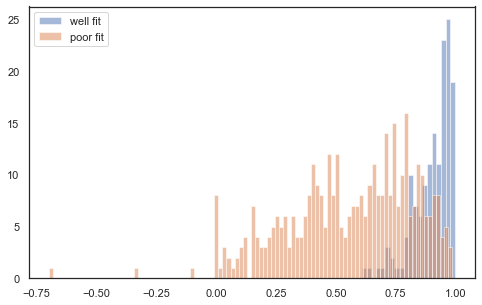

In [162]:
plt.figure(figsize=(8,5))
plt.hist(df3[df3.vis_well_fit == 1].R2, bins=20, alpha=0.5, label="well fit");
plt.hist(df3[df3.vis_well_fit == 0].R2, bins=100, alpha=0.5, label="poor fit");
plt.legend();
# plt.xlim(0.5,1);

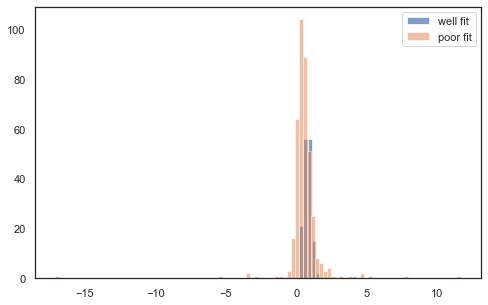

In [163]:
plt.figure(figsize=(8,5))
plt.hist(df3[df3.vis_well_fit == 1].OSI, bins=5, alpha=0.7, label="well fit");
plt.hist(df3[df3.vis_well_fit == 0].OSI, bins=100, alpha=0.5, label="poor fit");
plt.legend();
# plt.xlim(0,2);

In [164]:
df3['re_well_fit'] = ((df3.R2 > 0.8) & (df3.OSI > 0.2) & (df3.OSI < 1.5))
df3['re_vis_well_fit'] = ((df3.R2 > 0.8) & (df3.OSI > 0.2) & (df3.OSI < 1.5) & (df3.vis == 1))
df3.head()

C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ll357\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,area,vis,vis_well_fit,ori_perc_all,OSI,R2,re_well_fit,re_vis_well_fit
0,1,1,1,13.547029,0.663277,0.909820,True,True
1,1,1,0,48.059424,0.850999,0.912416,True,True
2,1,1,1,7.232809,1.092288,0.982684,True,True
3,1,1,1,9.414715,0.797583,0.936868,True,True
4,1,1,1,6.014102,0.873269,0.954914,True,True


In [165]:
df3.corr()

,area,vis,vis_well_fit,ori_perc_all,OSI,R2,re_well_fit,re_vis_well_fit
area,1.000000,-0.080810,-0.302078,0.230669,0.029047,-0.167217,-0.200528,-0.198129
vis,-0.080810,1.000000,0.168585,0.031716,-0.078676,0.031158,0.014160,0.200315
vis_well_fit,-0.302078,0.168585,1.000000,-0.756020,0.095778,0.561621,0.679287,0.720289
ori_perc_all,0.230669,0.031716,-0.756020,1.000000,-0.152942,-0.644296,-0.619682,-0.583252
OSI,0.029047,-0.078676,0.095778,-0.152942,1.000000,0.203248,0.106521,0.091304
R2,-0.167217,0.031158,0.561621,-0.644296,0.203248,1.000000,0.719522,0.684828
re_well_fit,-0.200528,0.014160,0.679287,-0.619682,0.106521,0.719522,1.000000,0.949261
re_vis_well_fit,-0.198129,0.200315,0.720289,-0.583252,0.091304,0.684828,0.949261,1.000000


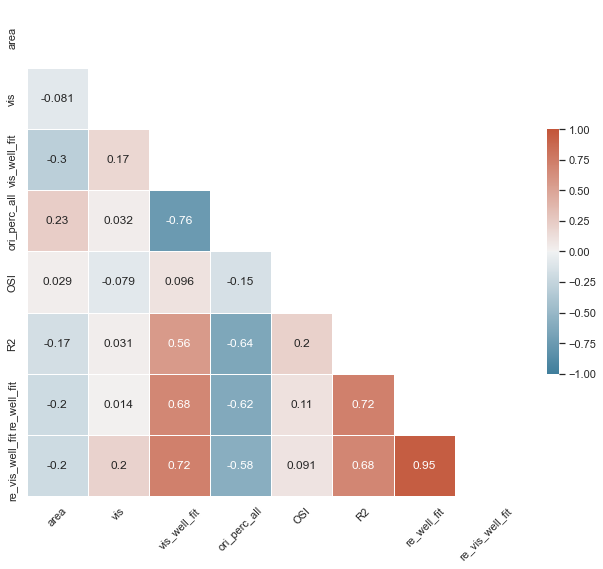

In [166]:
sns.set_theme(style="white")

f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(df3.corr(), dtype=bool)) # Generate a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

sns.heatmap(df3.corr(), mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True, 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=45);

### overlap btw new vs old well fit cells

In [167]:
df4 = df3.copy()
df4 = df4.drop(columns=['re_well_fit'])
df4['agree'] = (df3.re_vis_well_fit == df3.vis_well_fit).astype(int)
df4['overlap'] = ((df3.re_vis_well_fit) & (df3.vis_well_fit)).astype(int)
df4.re_vis_well_fit = df4.re_vis_well_fit.astype(int)

In [168]:
t1 = df4[['area','re_vis_well_fit','vis_well_fit','overlap','agree']].groupby('area', sort=False).mean().reset_index().values
t2 = df4[['area','re_vis_well_fit','vis_well_fit','overlap','agree']].groupby('area', sort=False).count().reset_index().values

df4[['area','re_vis_well_fit','vis_well_fit','overlap','agree']].groupby('area', sort=False).mean().reset_index()

,area,re_vis_well_fit,vis_well_fit,overlap,agree
0,1,0.436860,0.402730,0.361775,0.883959
1,2,0.281250,0.162500,0.150000,0.856250
2,3,0.197674,0.069767,0.069767,0.872093


In [169]:
tt = (t1[:,1:] * t2[:,1:]).astype(int)
df5 = pd.DataFrame(tt)
df5.columns = ['re_vis_well_fit', 'vis_well_fit', 'overlap', 'agree']
df5['total'] = t2[:,1].astype(int)
df5.index = ['V1', 'LM', 'LI']
df5

,re_vis_well_fit,vis_well_fit,overlap,agree,total
V1,128,118,106,259,293
LM,45,26,24,137,160
LI,17,6,6,75,86


### re_well_fit tuning bias across areas
filter: vis_driven by adapter & re_well_fit

In [170]:
file_path = os.path.join(root_path, "mat", "adp_dataset_master.xlsx").replace("\\","/")
meta = pd.read_excel(file_path, index_col=None)

meta = meta[meta.seg == 'segmented']
meta = meta[meta.mouse <= 1324]
meta = meta[['mouse','date','area']]
meta.mouse = meta.mouse.astype(int)
meta.date = meta.date.astype(int)
meta

,mouse,date,area
0,1322,200803,V1
1,1322,200804,LM
2,1322,200806,LI
3,1323,200720,V1
4,1323,200721,LM
5,1323,200723,LI
6,1324,200728,V1
7,1324,200729,LM


In [171]:
nset = len(meta.index); ncell = []; nori = 8; nisi = 3; nframe_trial = 223
dir_name = root_path + 'mat/'

vis_ad = np.empty([0,1]); vis_tg = np.empty([0,1]); well_fit = np.empty([0,1])
ori_pref = np.empty([0,nisi]); fit_param = np.empty([0,7,nisi])
dfof_ad = np.empty([0,1]); dfof_tg = np.empty([0,nori,nisi])
dfof_ad_std = np.empty([0,1]); dfof_tg_std = np.empty([0,nori,nisi])
trace = np.empty([0,nori,nisi,nframe_trial])

for iset in np.arange(nset):
    dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

    cell_prop = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'cell_property_loose' + '.mat'))
    dfof = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
    trace_align = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
    fit_tuning = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'fit_tuning_isi3' + '.mat'))
    
    ncell.append(len(cell_prop['vis_cell_ad']))    
    vis_ad = np.concatenate((vis_ad, cell_prop['vis_cell_ad']), axis=0)
    vis_tg = np.concatenate((vis_tg, cell_prop['vis_cell_noad_tg']), axis=0)
    well_fit = np.concatenate((well_fit, cell_prop['well_fit_cell']), axis=0)
    
    ori_pref = np.concatenate((ori_pref, cell_prop['ori_pref']), axis=0)
    fit_param = np.concatenate((fit_param, fit_tuning['fit_param']), axis=0)

    dfof_ad = np.concatenate((dfof_ad, dfof['dfof_ad']), axis=0)
    dfof_ad_std = np.concatenate((dfof_ad_std, dfof['dfof_ad_std']), axis=0)
    dfof_tg = np.concatenate((dfof_tg, dfof['dfof_tg']), axis=0)
    dfof_tg_std = np.concatenate((dfof_tg_std, dfof['dfof_tg_std']), axis=0)
    
    trace_flat = np.empty([ncell[iset],nori,nisi,nframe_trial]);
    for icell in np.arange(ncell[iset]):
        for iori in np.arange(nori):
            for iisi in np.arange(nisi):
                trace_flat[icell][iori][iisi][:] = trace_align['trace_avg'][icell][iori][iisi].flatten()
    trace = np.vstack((trace,trace_flat))

ncell, vis_ad.shape, vis_tg.shape, well_fit.shape, ori_pref.shape, fit_param.shape, dfof_ad.shape, dfof_tg.shape, trace.shape

([97, 69, 53, 103, 39, 33, 93, 52],
 (539, 1),
 (539, 1),
 (539, 1),
 (539, 3),
 (539, 7, 3),
 (539, 1),
 (539, 8, 3),
 (539, 8, 3, 223))

In [172]:
df4.head()

,area,vis,vis_well_fit,ori_perc_all,OSI,R2,re_vis_well_fit,agree,overlap
0,1,1,1,13.547029,0.663277,0.909820,1,1,1
1,1,1,0,48.059424,0.850999,0.912416,1,0,0
2,1,1,1,7.232809,1.092288,0.982684,1,1,1
3,1,1,1,9.414715,0.797583,0.936868,1,1,1
4,1,1,1,6.014102,0.873269,0.954914,1,1,1


In [173]:
tt = ori_pref.copy()
tt[tt > 90] = np.abs(tt[tt > 90] - 180)
tuning_bias = tt[:,[1,2]] - tt[:,[0]];

ori_pref_bin = tt[:,[0]];
ori_pref_bin[ori_pref_bin < 22.5] = 0; ori_pref_bin[ori_pref_bin > 67.5] = 90; 
ori_pref_bin[(ori_pref_bin >= 22.5) & (ori_pref_bin <= 67.5)] = 45; 

In [174]:
meta['ncell'] = ncell
mouse_cell = [item for item, count in zip(meta.mouse, meta.ncell) for i in range(count)]
area_cell = [item for item, count in zip(meta.area, meta.ncell) for i in range(count)]
meta_cell = pd.DataFrame({'mouse': mouse_cell, 'area': area_cell})
meta_cell_750 = meta_cell.copy(); meta_cell_750['isi'] = 750
meta_cell_250 = meta_cell.copy(); meta_cell_250['isi'] = 250
meta_cell_isi = pd.concat([meta_cell_750, meta_cell_250], ignore_index=True)

df_adp_tune = meta_cell_isi.copy()
df_adp_tune['tuning_bias'] = tuning_bias.flatten('F')
df_adp_tune['ori_pref_bin'] = np.concatenate((ori_pref_bin, ori_pref_bin), axis=0)

df_adp_tune['vis_ad'] = np.concatenate((vis_ad, vis_ad), axis=0)
df_adp_tune['well_fit'] = np.concatenate((well_fit, well_fit), axis=0)
df_adp_tune['re_well_fit'] = np.concatenate((df4.re_vis_well_fit, df4.re_vis_well_fit), axis=0) 
df_adp_tune = df_adp_tune[ df_adp_tune['vis_ad'] == 1 ]
# df_adp_tune = df_adp_tune[ df_adp_tune['well_fit'] == 1 ]
df_adp_tune = df_adp_tune[ df_adp_tune['re_well_fit'] == True ]

b, c = df_adp_tune.iloc[0].copy(), df_adp_tune.iloc[1].copy() 
df_adp_tune.iloc[0], df_adp_tune.iloc[1] = c, b # swap row 0 & 1 to sort df.gb properly
df_adp_tune.reset_index() #.head(20)

,index,mouse,area,isi,tuning_bias,ori_pref_bin,vis_ad,well_fit,re_well_fit
0,0,1322,V1,750,10.114118,0.0,1.0,0.0,1
1,1,1322,V1,750,12.848284,45.0,1.0,1.0,1
2,2,1322,V1,750,12.444471,0.0,1.0,1.0,1
3,3,1322,V1,750,3.611104,45.0,1.0,1.0,1
4,4,1322,V1,750,7.906208,45.0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...
353,1019,1324,V1,250,0.665259,45.0,1.0,1.0,1
354,1023,1324,V1,250,28.365979,45.0,1.0,1.0,1
355,1035,1324,LM,250,-17.315985,90.0,1.0,1.0,1
356,1046,1324,LM,250,-32.213886,90.0,1.0,0.0,1


In [175]:
df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area'], sort=False).describe()

tuning_bias                                                      \
           count      mean        std        min       25%       50%   
area                                                                   
V1         240.0  0.515157  12.335312 -46.021617 -5.378866  0.627152   
LM          84.0 -0.226789  17.536092 -54.713886 -6.395435 -0.219753   
LI          34.0 -1.770734  14.537416 -30.981503 -9.076292 -0.916809   

                             isi         ...               ori_pref_bin  \
           75%        max  count   mean  ...    75%    max        count   
area                                     ...                              
V1    7.678930  52.761022  240.0  500.0  ...  750.0  750.0        240.0   
LM    8.025647  64.036454   84.0  500.0  ...  750.0  750.0         84.0   
LI    1.853701  37.881488   34.0  500.0  ...  750.0  750.0         34.0   

                                                        
           mean        std  min  25%   50%   75%   max  
area                                                    
V1    38.250000  30.053300  0.0  0.0  45.0  45.0  90.0  
LM    38.571429  37.709826  0.0  0.0  45.0  90.0  90.0  
LI    52.941176  39.121366  0.0  0.0  45.0  90.0  90.0  

[3 rows x 24 columns]

In [176]:
df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).describe()

tuning_bias                                              \
                            count       mean        std        min        25%   
area isi ori_pref_bin                                                           
V1   750 0.0                 37.0   3.990129  10.654572 -21.603896  -2.933266   
         45.0                64.0   0.895338  14.117363 -38.851249  -5.310099   
         90.0                19.0  -3.739424   7.741475 -23.486719  -7.991605   
     250 0.0                 37.0   4.325438  11.855866 -18.283585  -1.249066   
         45.0                64.0  -0.747967  12.237526 -46.021617  -7.326305   
         90.0                19.0  -6.443211   9.974244 -26.746026 -11.543653   
LM   750 0.0                 18.0   2.490747  10.633685  -8.932493  -4.985287   
         45.0                12.0  -2.948628  17.429925 -32.388121 -16.782461   
         90.0                12.0 -13.533156  17.994166 -54.713886 -22.935972   
     250 0.0                 18.0   8.415005  19.698928 -20.713656  -1.833072   
         45.0                12.0   7.321856  11.515939  -8.430909   1.248990   
         90.0                12.0  -8.786227  17.551399 -52.018590 -11.068762   
LI   750 0.0                  5.0  10.717016  14.269474  -0.729991   0.170655   
         45.0                 4.0   0.300334   1.910064  -2.061516  -0.846494   
         90.0                 8.0  -8.517388   8.916429 -21.629065 -14.979433   
     250 0.0                  5.0   8.869741  17.245184  -4.561534  -3.592792   
         45.0                 4.0   0.898390  18.231054 -20.005974  -6.323337   
         90.0                 8.0 -11.849316  10.936407 -30.981503 -17.475166   

                                                        
                             50%        75%        max  
area isi ori_pref_bin                                   
V1   750 0.0            4.651256  10.904581  24.239947  
         45.0           3.509850   8.826613  52.761022  
         90.0          -4.015780   1.503156   9.064453  
     250 0.0            3.133522   9.510487  44.731535  
         45.0          -0.042094   4.029076  39.983653  
         90.0          -4.099333   0.201746   8.991512  
LM   750 0.0           -1.458961   8.082448  31.937337  
         45.0           3.618410   7.854493  23.843320  
         90.0          -8.805151   0.397576   7.657974  
     250 0.0            1.625707  14.499203  64.036454  
         45.0           7.125277   9.115673  34.735043  
         90.0          -3.145399   0.919672   8.365668  
LI   750 0.0            4.587597  16.435852  33.120966  
         45.0           0.703810   1.850638   1.855232  
         90.0          -7.952463  -0.770032   2.458009  
     250 0.0            5.396424   9.225118  37.881488  
         45.0          -0.407821   6.813905  24.415174  
         90.0         -11.565668  -4.486721   1.577763

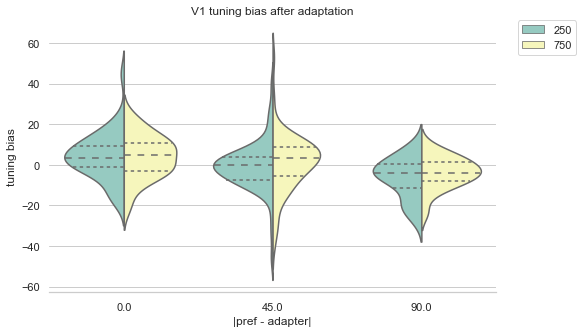

In [177]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
ax = sns.violinplot(data=df_adp_tune[df_adp_tune.area == 'V1'], 
                    x="ori_pref_bin", y="tuning_bias", hue="isi", 
                    split=True, inner="quart", palette="Set3")
sns.despine(left=True)
ax.set(xlabel = '|pref - adapter|', ylabel = 'tuning bias', title = 'V1 tuning bias after adaptation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

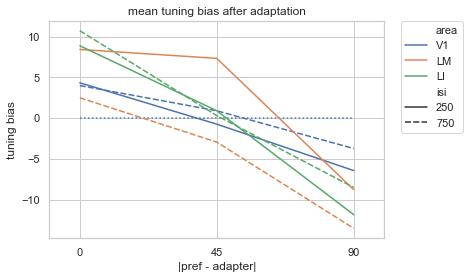

In [178]:
tt = df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).mean().reset_index()

ax = sns.lineplot(data=tt, x="ori_pref_bin", y="tuning_bias", hue="area", style="isi", ci='sd');
ax.set(xlabel = '|pref - adapter|', ylabel = 'tuning bias', title = 'mean tuning bias after adaptation')
plt.xlim([-10,100]); plt.xticks([0,45,90])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.hlines(0, 0, 90, linestyles='dotted');

In [213]:
# bias_mean = df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).mean().reset_index().to_numpy()[:,-1]

# bias_sem = df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).std().reset_index().to_numpy()[:,-1] / np.sqrt(df_adp_tune[['tuning_bias','area','isi','ori_pref_bin']].groupby(['area','isi','ori_pref_bin'], sort=False).count().reset_index().to_numpy()[:,-1].astype(float))

## fig 1C

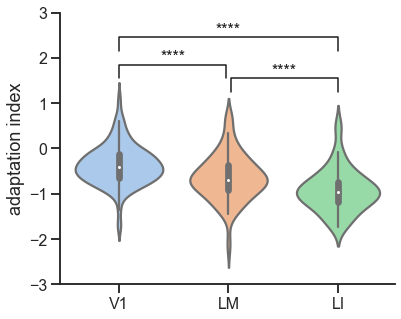

In [227]:
sns.set_style("ticks")
sns.set_context("talk", font_scale = 1)
fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)

ax = sns.violinplot(x="area", y="adp_mag", col="isi",
                data=df_adp_mag_thres[df_adp_mag_thres.isi==250], kind="violin",
                height=4, aspect=1, palette='pastel');

# statistical annotation
x1, x2 = 0, 0.98
y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 0.4, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

x1, x2 = 1.02, 2
y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 0.1, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

x1, x2 = 0, 2
y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 1, 0.3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

plt.xlabel('')
plt.ylabel('adaptation index', fontsize=18)
ax.set_xticklabels(['V1', 'LM', 'LI'], fontsize=18)
ax.set_yticks(np.arange(-3,3.1))
ax.set_ylim((-3,3))

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
sns.despine(ax=ax)

figtitle = 'Adaptation magnitude increases along ventral stream'
# ax.fig.suptitle(figtitle, size=16)
# ax.fig.subplots_adjust(top=.8)
plt.savefig(root_folder + 'plot/poster/' + figtitle + '.pdf', format='pdf')

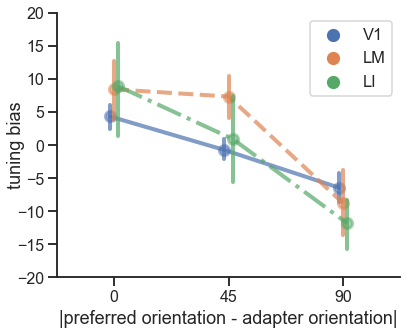

In [228]:
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale = 1)

fig, axes = plt.subplots(1, 1, figsize=(6, 5), sharey=True)
ax = sns.pointplot(ax=axes, x=df_adp_tune.ori_pref_bin.astype(int), y="tuning_bias", hue="area", 
                   data=df_adp_tune[df_adp_tune.isi==250], ci=68, dodge=True,
                   linestyles=["-", "--", "dashdot"])
plt.legend(title='', loc='upper right')
plt.setp(ax.collections, alpha=.5);
plt.setp(ax.lines, alpha=.7);
plt.ylim(-20,20)
plt.xlabel('|preferred orientation - adapter orientation|', labelpad=5, fontsize=18)
plt.ylabel('tuning bias', fontsize=18, labelpad=-8);

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
sns.despine(ax=ax)

figtitle = 'Tuning bias increases along ventral stream'
# fig.suptitle(figtitle)
plt.tight_layout()
plt.savefig(root_path + 'plot/poster/' + figtitle + '.pdf', format='pdf')

In [229]:
# sns.set_style("ticks")
# sns.set_context("talk", font_scale = 1)

# fig, ax = plt.subplots(1, 2)

# # ax[0].plot(range(10), 'r') #row=0, col=0


# ax = sns.violinplot(x="area", y="adp_mag", col="isi",
#                 data=df_adp_mag_thres[df_adp_mag_thres.isi==250], kind="violin",
#                 height=4, aspect=1, palette='pastel', ax=ax[0]);

# # statistical annotation
# x1, x2 = 0, 0.98
# y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 0.4, 0.3, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

# x1, x2 = 1.02, 2
# y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 0.1, 0.3, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

# x1, x2 = 0, 2
# y, h, col = np.max(df_adp_mag_thres[df_adp_mag_thres.isi==250].adp_mag.values) + 1, 0.3, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((x1+x2)*.5, y+h, "****", ha='center', va='bottom', color=col, fontsize=16)

# plt.xlabel('')
# plt.ylabel('adaptation index', fontsize=18)
# ax.set_xticklabels(['V1', 'LM', 'LI'], fontsize=18)
# ax.set_yticks(np.arange(-3,3.1))
# ax.set_ylim((-3,3))

# ax.tick_params(axis="x", labelsize=16)
# ax.tick_params(axis="y", labelsize=16)
# sns.despine(ax=ax)


# # ax[1].plot(range(10), 'b') #row=1, col=0
# plt.show()